In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib
import operator
import collections
from scipy import stats
from itertools import combinations
from statsmodels.stats.multitest import fdrcorrection

# Set 
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.size'] = 15

# Load Food Database Consumption for 2001-2003-2005

In [3]:
pathdir='./input_data/'
tablefoodyear=pd.read_csv(pathdir+'FNDDS_1999_2006_Weighted_Consumption_WWEIA_nuts_FPro.csv')
tablefoodyear.drop(columns='Unnamed: 0', inplace=True)

# NHANES 2003-2018 Food Source

In [4]:
foodsource=pd.read_csv(pathdir+'NHANES_2003_2018_FoodSource_Consumed.csv')
foodsource.drop(columns='Unnamed: 0', inplace=True)
foodsource['SEQN']=foodsource['SEQN'].apply(np.int)
foodsource['Food code']=foodsource['Food code'].apply(np.int)

In [5]:
# select only 2003-2005 to compare with the epidemiological study
foodsourcesel=foodsource[foodsource['year'].isin([2003,2005])]
foodsourcesel=foodsourcesel[foodsourcesel['Food source'].notna()]

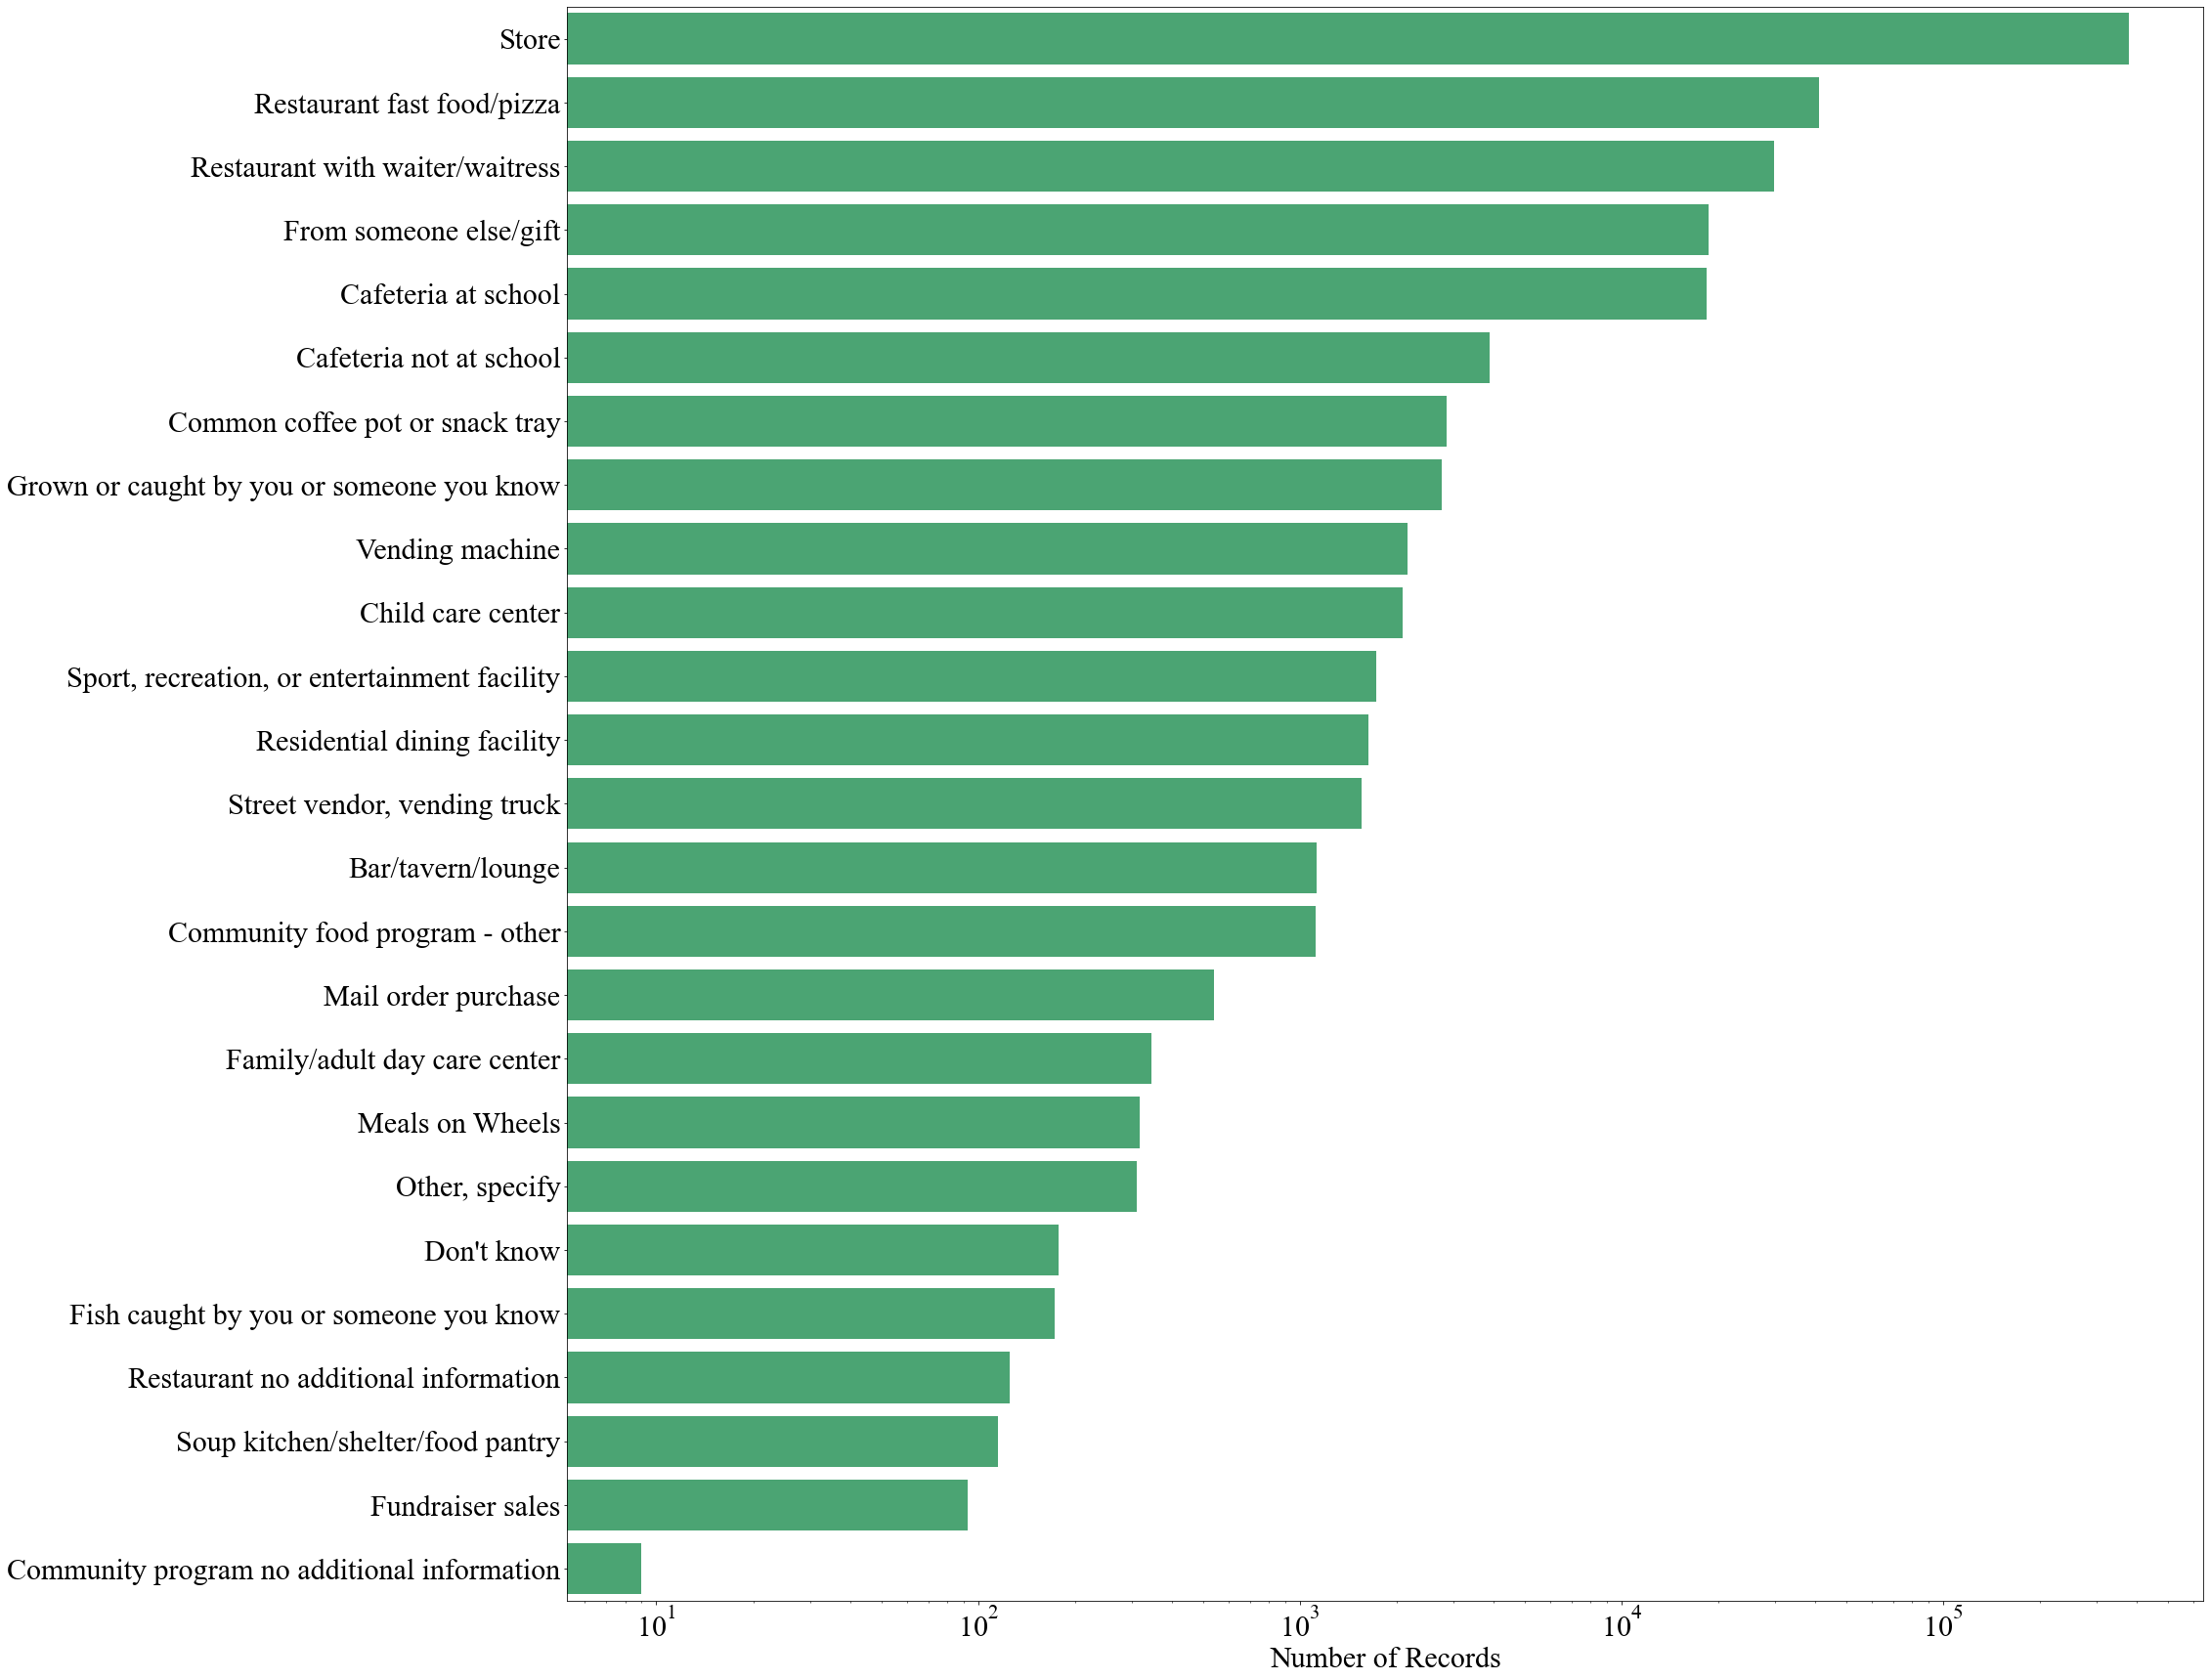

In [6]:
counterST=collections.Counter(foodsourcesel['Food source'])
counterSTkey=sorted(counterST, key=counterST.get, reverse=True)
counttypes=[counterST[k] for k in counterSTkey]
plt.figure(figsize = (30, 30))
ax = sns.barplot(x = counttypes, y=counterSTkey,  color="mediumseagreen")
ax.set_ylabel('')
ax.set_xlabel('Number of Records', fontsize=30)
ax.set_xscale('log')
plt.setp(ax.get_xticklabels(), fontsize=30)
plt.setp(ax.get_yticklabels(), fontsize=30);

In [7]:
# merge tables
merget=foodsourcesel.merge(tablefoodyear, on=["year", "Food code"], how='left')
merget=merget[['SEQN', 'year', 'day', 'Food code', 'Food source code',
       'Grams consumed', 'Dietary recall status', 'Food source',
       'Main food description', 'cat_digit_1', 'cat_digit_2', 'cat_digit_3',
       'cat_digit_4', 'cat_digit_5', 'WWEIA Category number',
       'WWEIA Category description', 'year_WWEIA_category', 'n', 'se.n',
       'Grams', 'Calories', 'se.Grams', 'se.Calories', 'FPS', 'ens_FPS',
       'ens_min_FPS']]

# Analysis of FPro
FPS (Food Processing Score) is equivalent to FPro

In [8]:
whichscore='ens_FPS'
foodsource=list(set(merget['Food source']))
mv=[merget[whichscore][merget['Food source']==w].median() for w in foodsource]
foodsource_s=[foodsource[i] for i in np.argsort(mv)]

# values for boxplot
x=[w for w in foodsource_s for ind in range(sum(merget['Food source']==w))]
y=[val for w in foodsource_s for val in merget[whichscore][merget['Food source']==w]]
s=[sum(merget['Food source']==w) for w in foodsource]
foodsourceDB=pd.DataFrame.from_dict({'Source': foodsource, 'Size': s, 'MedianFPS': mv}).sort_values(by=['Size'], ascending=False)

In [9]:
# most interesting/representative food sources
sourcesel=['Store',
 'Restaurant fast food/pizza',
 'Restaurant with waiter/waitress',
 'Cafeteria at school',
 'Cafeteria not at school',
 'Grown or caught by you or someone you know',
 'Vending machine',
'Residential dining facility',
'Street vendor, vending truck',
'Bar/tavern/lounge']

In [10]:
# sample sizes and median FPro
foodsourceDB[foodsourceDB['Source'].isin(sourcesel)]

,Source,Size,MedianFPS
22,Store,378420,0.788875
11,Restaurant fast food/pizza,41215,0.906000
12,Restaurant with waiter/waitress,29902,0.824750
10,Cafeteria at school,18377,0.862944
7,Cafeteria not at school,3893,0.735148
15,Grown or caught by you or someone you know,2755,0.442342
0,Vending machine,2162,0.979986
3,Residential dining facility,1630,0.623815
20,"Street vendor, vending truck",1553,0.897982
21,Bar/tavern/lounge,1132,0.773382


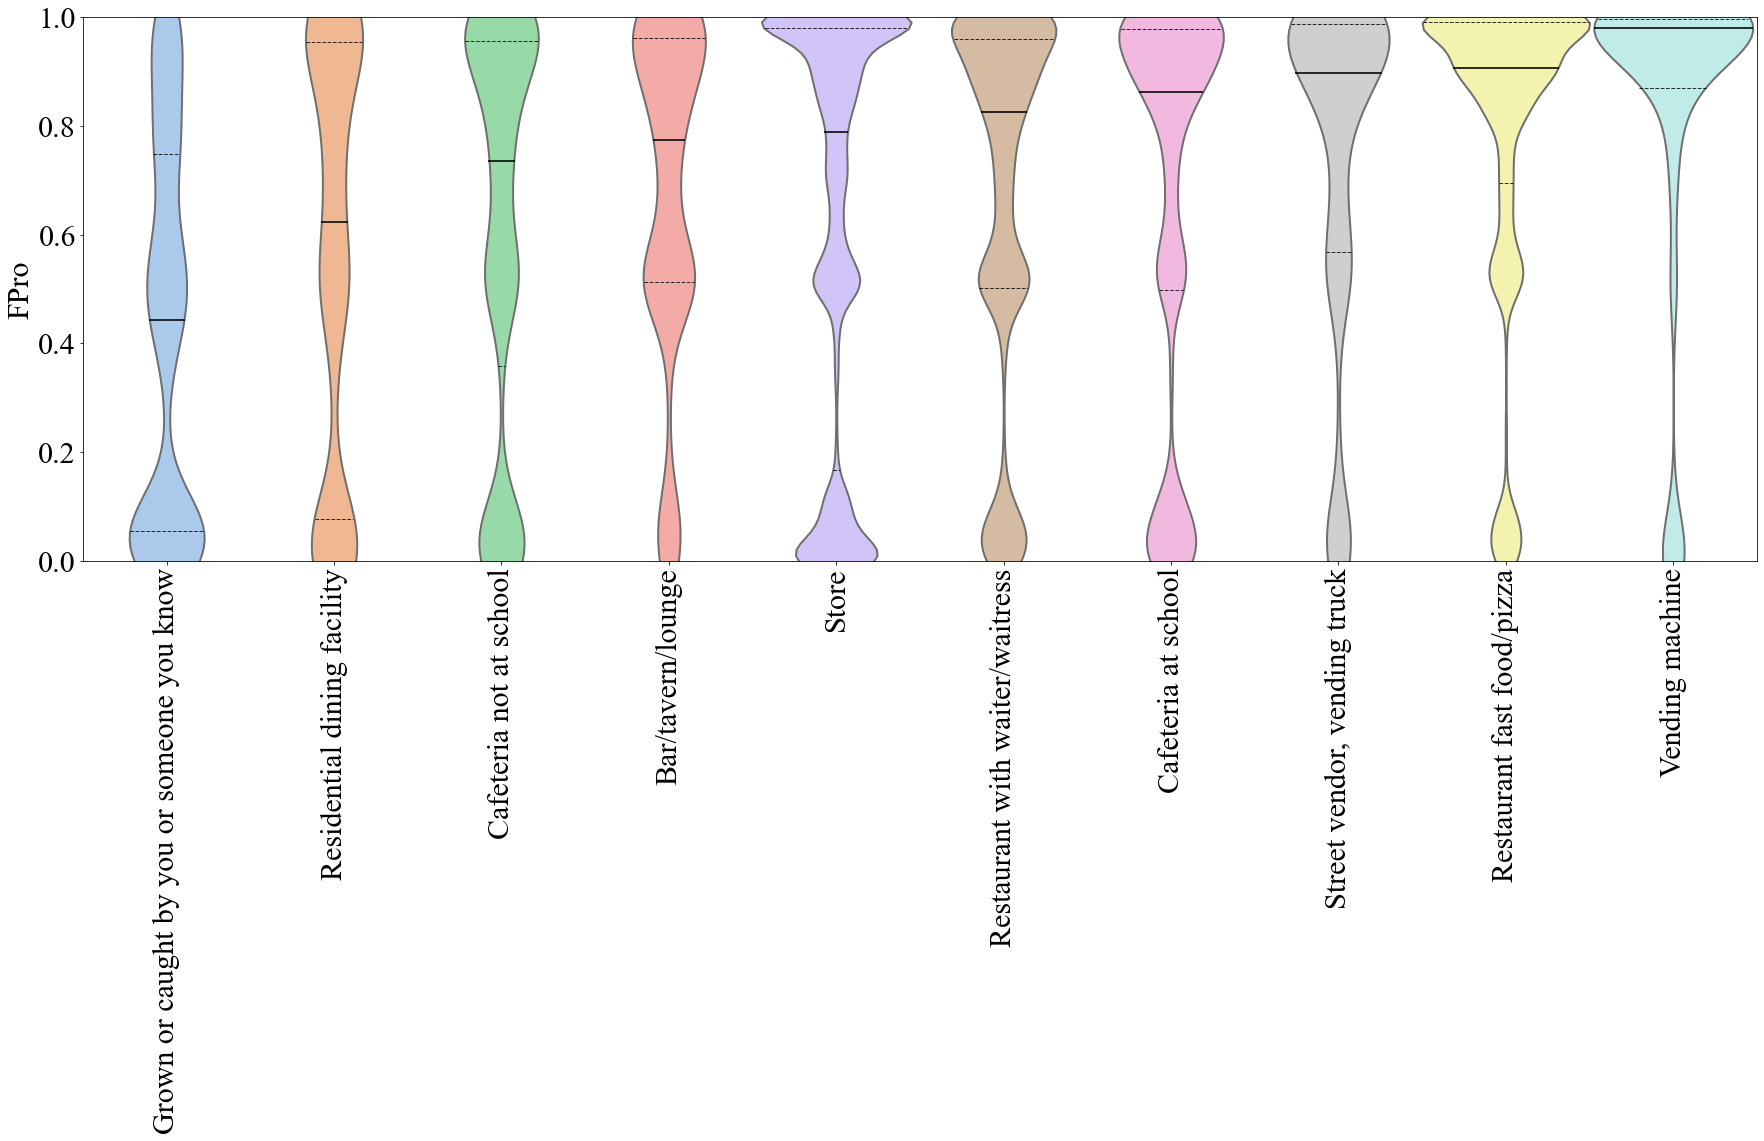

In [11]:
# values for boxplot filtered
mv=[foodsourceDB['MedianFPS'][foodsourceDB['Source']==w].iloc[0] for w in sourcesel]
sourcesel_s=[sourcesel[i] for i in np.argsort(mv)]
x=[w for w in sourcesel_s for ind in range(sum(merget['Food source']==w))]
y=[val for w in sourcesel_s for val in merget[whichscore][merget['Food source']==w]]

fig, ax = plt.subplots(figsize=(30, 10))
ax1=sns.violinplot(x=x, y=y, inner="quartile", width=1, palette=sns.color_palette("pastel"), linewidth=2)
ax.set_xlabel("")
ax.set_ylabel("FPro", fontsize=30)
ax.set_ylim(0, 1);
for l in ax1.lines:
    l.set_linestyle('--')
    l.set_linewidth(1)
    l.set_color('black')
    l.set_alpha(0.8)
for l in ax1.lines[1::3]:
    l.set_linestyle('-')
    l.set_linewidth(2)
    l.set_color('black')

plt.setp(ax.get_xticklabels(), fontsize=30)
plt.setp(ax.get_yticklabels(), fontsize=30)
plt.setp(ax.get_xticklabels(), rotation=90);

# Summary Statistics

In [12]:
# dictionary for statistical tests
dictsourcevalues={w:[val for val in merget[whichscore][merget['Food source']==w]] for w in sourcesel_s}

# Kruskal-Wallis H-test
# Global Test

In [13]:
gt=stats.kruskal(dictsourcevalues['Grown or caught by you or someone you know'],
              dictsourcevalues['Residential dining facility'],
             dictsourcevalues['Cafeteria not at school'],
             dictsourcevalues['Bar/tavern/lounge'],
             dictsourcevalues['Store'],
             dictsourcevalues['Restaurant with waiter/waitress'],
             dictsourcevalues['Cafeteria at school'],
             dictsourcevalues['Street vendor, vending truck'],
             dictsourcevalues['Restaurant fast food/pizza'],
             dictsourcevalues['Vending machine'])
gt

KruskalResult(statistic=7152.685718238855, pvalue=0.0)

# Pair test: Kruskal-Wallis H-test and Mann-Whitney U test
Estimate Effect Size for Mann-Whitney U test
http://www.real-statistics.com/non-parametric-tests/mann-whitney-test/
https://nickredfern.wordpress.com/2011/05/12/the-mann-whitney-u-test/
https://www.real-statistics.com/non-parametric-tests/wilcoxon-rank-sum-test/

In [14]:
alphav=0.01
comblist=[p for p in combinations(sourcesel, 2)]
testDB=pd.DataFrame.from_dict({'Pair': comblist, 'pvalueKW': [stats.kruskal(dictsourcevalues[c[0]], dictsourcevalues[c[1]]).pvalue for c in comblist],
                              'Hstatistic': [stats.kruskal(dictsourcevalues[c[0]], dictsourcevalues[c[1]]).statistic for c in comblist],
                              'pvalueMW':[stats.mannwhitneyu(dictsourcevalues[c[0]], dictsourcevalues[c[1]]).pvalue for c in comblist],
                              'U1': [stats.mannwhitneyu(dictsourcevalues[c[0]], dictsourcevalues[c[1]]).statistic for c in comblist]}).sort_values(by=['pvalueMW'])

testDB['n1']=[len(dictsourcevalues[c[0]]) for c in testDB['Pair']]
testDB['n2']=[len(dictsourcevalues[c[1]]) for c in testDB['Pair']]
testDB['U2']=testDB['n1']*testDB['n2']-testDB['U1']
testDB['U']=testDB[['U1', 'U2']].min(axis = 1)
testDB['mu']=testDB['n1']*testDB['n2']/2
testDB['sigma']=(testDB['n1']*testDB['n2']*(testDB['n1']+testDB['n2']+1)/12).apply(np.sqrt)
testDB['z']=(abs(testDB['U']-testDB['mu'])-0.5)/testDB['sigma']
testDB['r_effectsize']=testDB['z']/np.sqrt(testDB['n1']+testDB['n2'])
testDB['p_effectsize']=abs(0.5-testDB['U']/(testDB['n1']*testDB['n2']))
testDB['BHpvalue']=fdrcorrection(testDB['pvalueMW'], alpha=alphav)[1]
testDB['Bonferroni']=testDB['pvalueMW']<(alphav/len(comblist))

A rough estimate of effect size is that r = .5 represents a large effect size, r = .3 represents a medium effect size and r = .1 represents a small effect.

In [15]:
# sorting for effect size
testDB.sort_values(by=['r_effectsize'], ascending=False)

,Pair,pvalueKW,Hstatistic,pvalueMW,U1,n1,n2,U2,U,mu,sigma,z,r_effectsize,p_effectsize,BHpvalue,Bonferroni
35,"(Grown or caught by you or someone you know, V...",0.000000e+00,1653.946156,0.000000e+00,9.694500e+05,2755,2162,4.986860e+06,9.694500e+05,2.978155e+06,4.940743e+04,40.655918,0.579794,0.337240,0.000000e+00,True
37,"(Grown or caught by you or someone you know, S...",2.101276e-179,815.682322,1.051021e-179,1.019874e+06,2755,1553,3.258640e+06,1.019874e+06,2.139258e+06,3.919622e+04,28.558432,0.435107,0.261629,4.729596e-179,True
39,"(Vending machine, Residential dining facility)",4.680480e-123,556.572175,2.341069e-123,9.751530e+05,2162,1630,2.548907e+06,9.751530e+05,1.762030e+06,3.337509e+04,23.576760,0.382869,0.223287,7.023208e-123,True
31,"(Cafeteria not at school, Vending machine)",7.378195e-158,716.590962,3.689857e-158,2.464147e+06,3893,2162,5.952519e+06,2.464147e+06,4.208333e+06,6.517370e+04,26.762108,0.343925,0.207230,1.277258e-157,True
38,"(Grown or caught by you or someone you know, B...",3.887502e-99,446.638529,1.944399e-99,8.876000e+05,2755,1132,2.231060e+06,8.876000e+05,1.559330e+06,3.178751e+04,21.131869,0.338946,0.215391,4.860997e-99,True
41,"(Vending machine, Bar/tavern/lounge)",7.160775e-81,362.730829,3.581708e-81,7.305895e+05,2162,1132,1.716794e+06,7.305895e+05,1.223692e+06,2.592317e+04,19.021669,0.331426,0.201481,8.482993e-81,True
30,"(Cafeteria not at school, Grown or caught by y...",1.349630e-101,457.939864,6.749086e-102,3.713015e+06,3893,2755,7.012200e+06,3.713015e+06,5.362608e+06,7.708867e+04,21.398631,0.262446,0.153805,1.786523e-101,True
12,"(Restaurant fast food/pizza, Grown or caught b...",0.000000e+00,2788.935590,0.000000e+00,2.271801e+07,41215,2755,9.082931e+07,2.271801e+07,5.677366e+07,6.450316e+05,52.796871,0.251785,0.299925,0.000000e+00,True
40,"(Vending machine, Street vendor, vending truck)",3.247126e-47,208.287467,1.623928e-47,1.213848e+06,2162,1553,2.143738e+06,1.213848e+06,1.678793e+06,3.224488e+04,14.419156,0.236570,0.138476,3.479847e-47,True
25,"(Cafeteria at school, Grown or caught by you o...",2.863304e-254,1160.099710,1.431734e-254,1.514481e+07,18377,2755,3.548382e+07,1.514481e+07,2.531432e+07,2.985988e+05,34.057419,0.234283,0.200865,1.073800e-253,True
